# Import libraries and set configs

In [ ]:
from typing import Union, Tuple 

import sys
sys.path.append("..")

import os
import json
import glob
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval

from dotenv import load_dotenv, find_dotenv
# here we load environment variables from .env, must be called before init. class
load_dotenv(find_dotenv('../.env'), verbose=True)

# Set environment variable
environ["ENV"] = "optimize"

tv_username = os.getenv("TV_USERNAME")
tv_password = os.getenv("TV_PASSWORD")

class CFG:
    load = False
    historical = False
    create_dataset = False
    update_dataset = False
    cls_target_ratio_tp = 1.05
    cls_target_ratio_sl = 1.05
    # last previous data point to collect for model training (value represents number of hours before signal point)
    last = 272
    # for how long time (in hours) we want to predict
    target_offset = 128
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = False
    optimize = False
    # maximum number of simultaneously opened trades
    max_num_simult_trades = 100
    # significance level, is used to conduct a t-test between 2 models
    optimize_alpha = 0.2 
    n_repeats = 1
    n_folds = 8
    min_precision = 0.5
    last_date = datetime.strptime("2024-10-20:18:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat)

### Load STOCH_RSI sell data

In [3]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat)

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:

counter = 0 

tickers_1h = glob.glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/3087 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

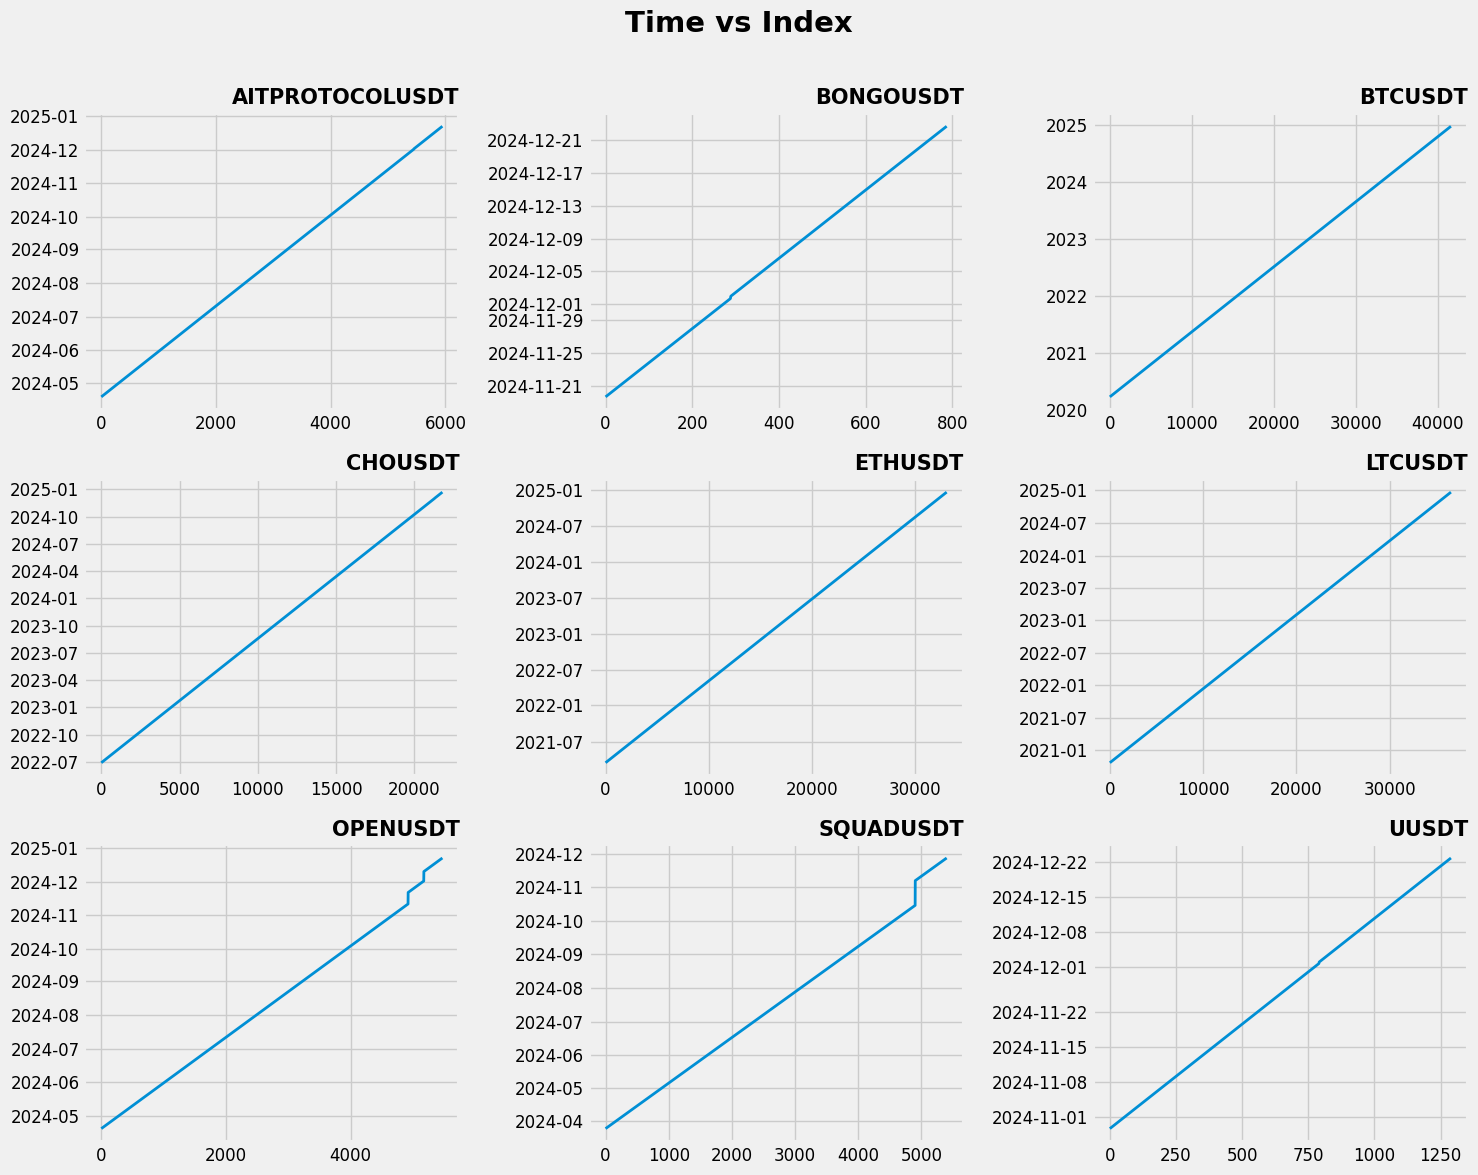

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob.glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = {i[31:].split("USDT")[0] + "USDT" for i in x}
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["min_price_deviation"] = 0
            row["first_price"] = 0
            row["last_price"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]
            

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue

            row["first_price"] = close_price.values[0]
            row["close_time"] = row["time"].values[0] + pd.to_timedelta(target_offset, unit="h")
            
            close_price = close_price.values[0]
            if ttype == "buy":
                higher_price = close_price * CFG.cls_target_ratio_sl
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            else:
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_sl)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    break
                elif tp1 or tp2:
                    # if reach TP - write the time when the trade was closed (but only one time)
                    if row["close_time"].values[0] == row["time"].values[0] + pd.to_timedelta(target_offset, unit="h"):
                        row["close_time"] = row["time"].values[0] + pd.to_timedelta(i, unit="h")
                    row["target"] = 1
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price
                    # if price doesn't reach both TP and SL - write its last price
                    if row["target"].values[0] == 0:
                        row["last_price"] = last_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price_pos = (target_buy - close_price) / close_price
                    curr_price_neg = (close_price - target_sell) / close_price
                else:
                    curr_price_pos = (close_price - target_sell) / close_price
                    curr_price_neg = (target_buy - close_price) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price_pos) 
                row["min_price_deviation"] = max(row["min_price_deviation"].values[0], curr_price_neg) 
            
            if pass_cycle:
                continue
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    # buy_hours_to_save = [0, 1, 3, 15, 16, 17, 18, 19, 21, 22, 23]
    buy_hours_to_save = [0, 1, 3, 7, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    # sell_hours_to_save = [2, 5, 8, 9, 11, 14, 17]
    sell_hours_to_save = [0, 1, 5, 22, 23]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, CFG.target_offset, first, CFG.last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, CFG.target_offset, first, CFG.last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, CFG.target_offset, first, CFG.last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{CFG.last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{CFG.last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation",
                                                              "min_price_deviation", "ticker", "ttype", "close_time", "first_price", "last_price"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # check if columns that were added for backtest and statistics are correct
    for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
        if row["last_price"] > 0:
            assert row["close_time"] - row["time"] == pd.to_timedelta(CFG.target_offset, unit="h")
            assert round(row["max_price_deviation"], 8) <= CFG.cls_target_ratio_tp - 1
        else:
            assert row["close_time"] - row["time"] <= pd.to_timedelta(CFG.target_offset, unit="h")
            if row["target"] == 1:
                assert round(row["max_price_deviation"], 8) >= CFG.cls_target_ratio_tp - 1
            else:
                assert round(row["max_price_deviation"], 8) < CFG.cls_target_ratio_tp - 1

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_sl
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+CFG.target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        high_price = close_price * CFG.cls_target_ratio_tp
        low_price = close_price * (2 - CFG.cls_target_ratio_sl)
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+CFG.target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Find minimum acceptable class 1 / class 0 ratio considering singal statistics and our TP / SL ratio

In [13]:
# if target = 1 but price didn't reach TP - what is percent of cases when it happenes and what is average positive price movement
low_price_dev_num_1 = train_buy.query("target == 1 & max_price_deviation < @CFG.cls_target_ratio_tp - 1").shape[0]
normal_price_dev_num_1 = train_buy.query("target == 1").shape[0]
avg_low_price_dev_1 = train_buy.query("target == 1 & max_price_deviation < @CFG.cls_target_ratio_tp - 1")["max_price_deviation"].mean()
low_2_norm_ratio_1 = low_price_dev_num_1/normal_price_dev_num_1

# if target = 0 but price didn't reach SL - what is percent of cases when it happenes and what is average negative price movement
low_price_dev_num_0 = train_buy.query("target == 0 & min_price_deviation < @CFG.cls_target_ratio_sl - 1").shape[0]
normal_price_dev_num_0 = train_buy.query("target == 0").shape[0]
avg_low_price_dev_0 = train_buy.query("target == 0 & min_price_deviation < @CFG.cls_target_ratio_sl - 1")["min_price_deviation"].mean()
low_2_norm_ratio_0 = low_price_dev_num_1/normal_price_dev_num_0

for class_1_ratio in np.arange(0.51, 0, -0.001):
    expectation = ((CFG.cls_target_ratio_tp - 1) * (1 - low_2_norm_ratio_1) + avg_low_price_dev_1 * low_2_norm_ratio_1) * class_1_ratio -\
           ((CFG.cls_target_ratio_sl - 1) * (1 - low_2_norm_ratio_0) + avg_low_price_dev_0 * low_2_norm_ratio_0) * (1 - class_1_ratio)
    if expectation < 0:
        print(round(class_1_ratio + 0.001, 4))
        break

0.501


### Test pattern / target distribution

In [14]:
def q10(x):
    return x.quantile(0.1)

def q20(x):
    return x.quantile(0.2)

def q30(x):
    return x.quantile(0.3)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))
# find hours where lower trust interval of class 1 / class 0 ratio 
# is bigger than minimum acceptable class 1 / class 0 ratio
mask = pvt["trust_interval"].apply(lambda x: x[0]) > class_1_ratio
display(pvt.loc[mask, "hour"].tolist())

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q20, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q20", 
               "max_price_dev_q30", "max_price_dev_q90", 
               "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))
# find hours where lower trust interval of class 1 / class 0 ratio 
# is bigger than minimum acceptable class 1 / class 0 ratio
mask = pvt["trust_interval"].apply(lambda x: x[0]) > class_1_ratio
display(pvt.loc[mask, "hour"].tolist())

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.117461,0.054615,0.066008,0.080024,0.291626,1727,3333,0.518152,"(0.5013, 0.535)"
3,1,1,0.112500,0.055021,0.064111,0.076687,0.297417,1519,2908,0.522352,"(0.5043, 0.5404)"
5,3,1,0.109576,0.055087,0.065482,0.075243,0.283435,1410,2696,0.522997,"(0.5042, 0.5418)"
7,7,1,0.109959,0.056815,0.067129,0.081559,0.298654,1220,2350,0.519149,"(0.4991, 0.5392)"
9,10,1,0.109902,0.056051,0.066065,0.076014,0.276256,1337,2506,0.533520,"(0.5141, 0.553)"
11,15,1,0.108796,0.054192,0.062439,0.074906,0.253867,1074,2081,0.516098,"(0.4947, 0.5375)"
13,16,1,0.117052,0.054399,0.066363,0.079926,0.273816,1207,2233,0.540528,"(0.52, 0.5611)"
15,17,1,0.120898,0.054242,0.064334,0.080270,0.303341,1324,2474,0.535166,"(0.5156, 0.5547)"
17,18,1,0.123980,0.055629,0.068195,0.083079,0.302220,1541,2895,0.532297,"(0.5142, 0.5504)"
19,19,1,0.115894,0.056501,0.068267,0.082261,0.293070,1658,2977,0.556937,"(0.5392, 0.5747)"


buy    44791
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    23642
0       STOCH_RSI_Volume24    21149
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.527829
0       STOCH_RSI_Volume24    0.472171
dtype: float64

[0, 1, 3, 10, 16, 17, 18, 19, 20, 21, 22, 23]

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q20,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.112427,0.055677,0.068056,0.080317,0.344029,1718,3178,0.540592,"(0.5234, 0.5578)"
3,1,1,0.111754,0.055501,0.064961,0.077074,0.322118,1628,3163,0.514701,"(0.4974, 0.532)"
5,5,1,0.116682,0.056136,0.067633,0.080442,0.353010,1428,2761,0.517204,"(0.4987, 0.5357)"
7,22,1,0.106959,0.053647,0.064290,0.075038,0.315083,1444,2728,0.529326,"(0.5107, 0.548)"
9,23,1,0.110403,0.055793,0.066088,0.078057,0.352558,1508,2841,0.530799,"(0.5125, 0.5491)"


sell    16451
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    8658
0       STOCH_RSI_Volume24    7793
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.52629
0       STOCH_RSI_Volume24    0.47371
dtype: float64

[0, 22, 23]

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

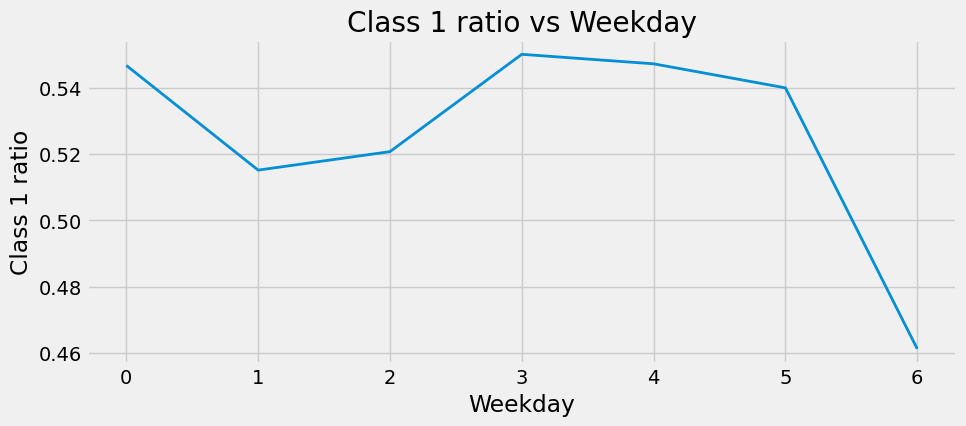

In [15]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

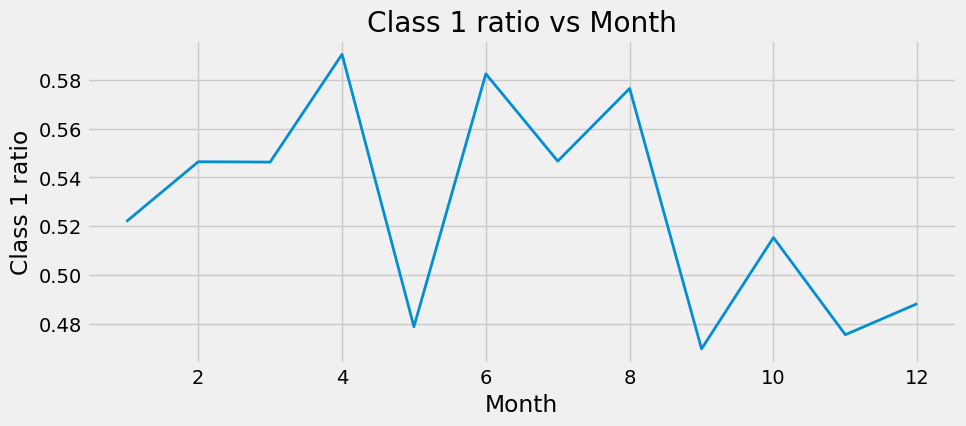

In [16]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

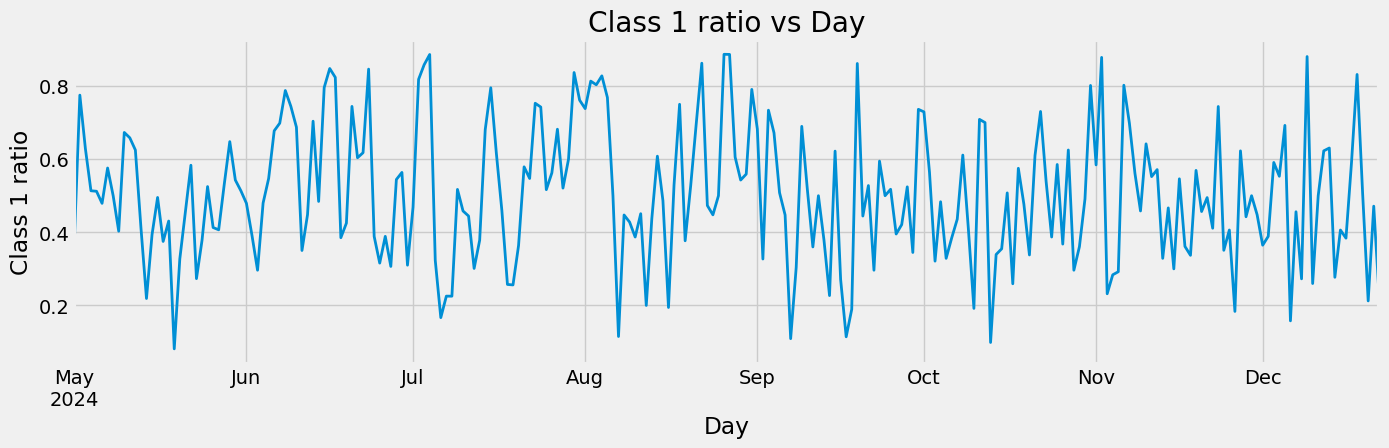

In [17]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

In [18]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_sl
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [19]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=CFG.target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_sl)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

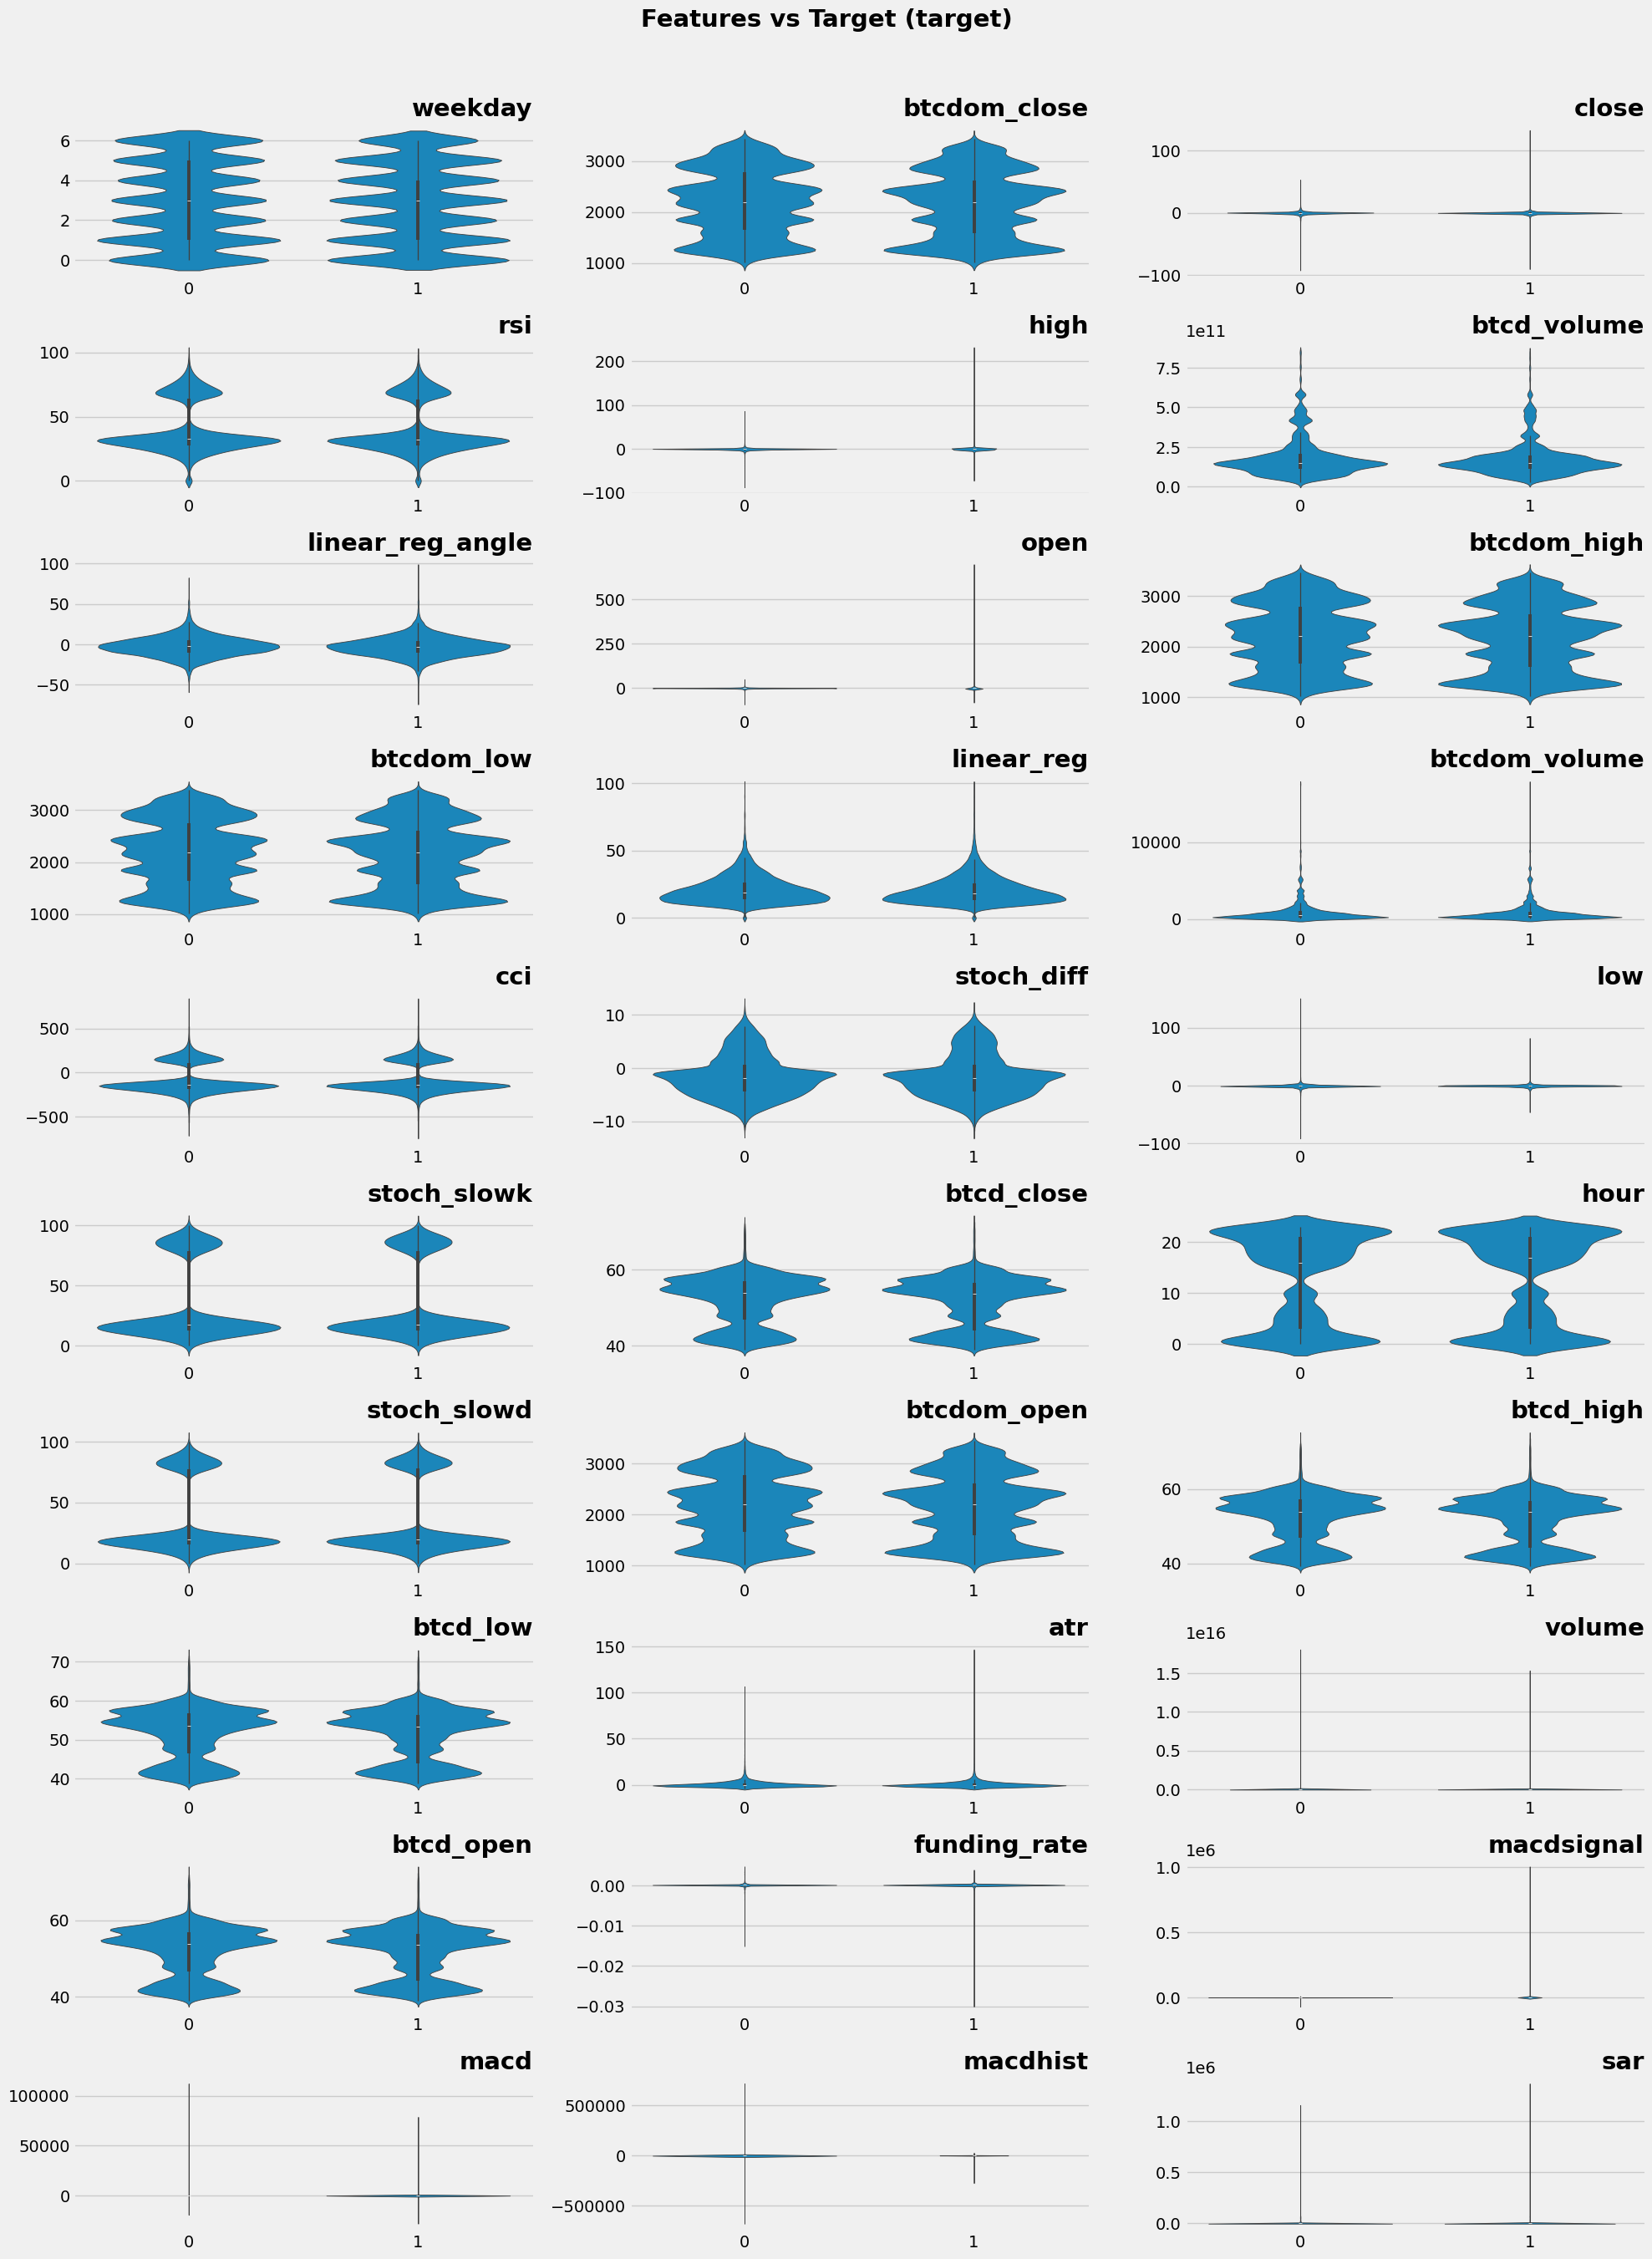

In [20]:
train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday

fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [21]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(50)

,time,ticker,ttype,pattern
182937,2024-12-22 07:00:00,MAFUSDT,buy,STOCH_RSI_Volume24
182938,2024-12-22 07:00:00,LKYUSDT,buy,STOCH_RSI_Volume24
182939,2024-12-22 07:00:00,1000TOSHIUSDT,buy,STOCH_RSI_Volume24
182940,2024-12-22 07:00:00,AEROUSDT,buy,STOCH_RSI_Volume24
182941,2024-12-22 07:00:00,VRUSDT,buy,STOCH_RSI_Volume24
182942,2024-12-22 07:00:00,MOEWUSDT,buy,STOCH_RSI_Volume24
182943,2024-12-22 07:00:00,PENGUUSDT,buy,STOCH_RSI_Volume24
182944,2024-12-22 08:00:00,CHEXUSDT,buy,STOCH_RSI_Volume24
182945,2024-12-22 08:00:00,SENDUSDT,buy,STOCH_RSI_Volume24
182946,2024-12-22 08:00:00,HIVE_USDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [ ]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "gbdt",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 6,
          "subsample" : 0.7,
          "colsample_bytree": 0.7,
          "verbosity": -1,
          "importance_type": "gain",
          "objective": "binary",
          "metric": "average_precison",
          "verbose": -1
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "weight",
                                                     "max_price_deviation", "min_price_deviation", "close_time", "first_price", "last_price"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000, perc=99)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError as re:
            print(re)
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [23]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# load the list of Bybit tickers
with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=(len(X) * 2) // (CFG.n_folds * 3))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=4, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [ ]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([
        perm_df_[["Feature","rank"]], 
        feature_importances_[["Feature","rank"]], 
        rfe_df_[["Feature","rank"]],
        boruta_df_[["Feature","rank"]],
                    ])
    fi = fi.groupby("Feature")["rank"].sum().reset_index()
    # weekday is a very important feature, it must be among features anyway
    fi.loc[fi["Feature"] == "weekday", "rank"] = fi.loc[fi["Feature"] == "weekday", "rank"].values[0] / 100
    fi = fi.sort_values("rank").reset_index(drop=True)
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

### Load best parameters from Optuna dataframe

In [26]:
def load_params_from_optuna(row_num=0) -> dict:
    try:
        optuna_df = pd.read_csv("optuna/optuna_lgbm.csv")
    except FileNotFoundError:
        return {}
    columns = [c for c in optuna_df.columns if c.startswith("params_")]
    row = optuna_df[columns].iloc[row_num]
    params = {key[7:]: value for key, value in row.to_dict().items()}
    if params["sample_weight"] != params["sample_weight"]:
        params["sample_weight"]  = None
    if params["is_unbalance"] is True:
        if "class_weight" not in params or params["class_weight"] != params["class_weight"]:
            params["class_weight"] = None
        else:
            params["class_weight"] = "balanced"
    return params

params = load_params_from_optuna(row_num=0)
params

{'boosting_type': 'goss',
 'colsample_bytree': 0.8365517403039056,
 'corr_thresh': 0.9352221428217052,
 'feature_num': 54,
 'high_bound': 0.452919193896923,
 'is_unbalance': False,
 'learning_rate': 0.1031447130550914,
 'low_bound': 0.0,
 'max_bin': 55,
 'max_depth': 10,
 'max_train_size': 0.5724623372589988,
 'n_estimators': 1216,
 'num_leaves': 237,
 'reg_alpha': 2.82821111868164,
 'reg_lambda': 0.0176228089798131,
 'sample_weight': None,
 'subsample': nan}

### Functions for train

In [28]:
from __future__ import annotations
from scipy.stats import ttest_rel


def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, sample_weight: Union[list, None],
                n_folds: int, low_bound: float, high_bound: float, train_test: str, 
                max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    val_idxs = []
    conf_scores =[]
    conf_object_nums = []
    max_train_size = int(len(df) * max_train_size)
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])

                plt.plot(train_df.index[fit_idx], [fold + 1] * len(fit_idx), label=f'Train {fold + 1}', color='blue')
                plt.plot(train_df.index[val_idx], [fold + 1] * len(val_idx), label=f'Test {fold + 1}', color='red')
                
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            if sample_weight is not None:
                sample_weight = df.loc[fit_idx, "weight"]
            else:
                sample_weight = None
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, sample_weight=sample_weight, 
                          eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:, 1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score - 1) * conf_obj_num)}")
        
        if verbose:
            plt.ylim(0.5, n_folds + 0.5)
            plt.xlabel('Index')
            plt.ylabel('Fold')
            plt.title('Train/Test Distribution for Time-Series Split')
            plt.legend(['Train', 'Test'], loc='lower right')
            plt.show()
        
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == "inference":
        print("Train on the latest data")
        X, y = df.iloc[-max_train_size:][features], df.iloc[-max_train_size:]["target"]
        if sample_weight is not None:
                sample_weight = df.iloc[-max_train_size:]["weight"]
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, sample_weight=sample_weight, eval_set=[(X, y)], 
                      eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Load selected features

In [27]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

if "feature_num" in params:
    feature_num = params["feature_num"]
    corr_thresh = params["corr_thresh"]

    del params["feature_num"]
    del params["corr_thresh"]

fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)

if "weekday" not in features:
    features.append("weekday")

assert len(features) == len(set(features))

display(features, len(features))

['weekday',
 'btcdom_close',
 'close',
 'rsi',
 'high',
 'btcd_volume',
 'linear_reg_angle',
 'btcdom_volume_prev_4',
 'btcdom_volume_prev_12',
 'btcdom_volume_prev_16',
 'btcdom_volume_prev_20',
 'btcd_volume_prev_24',
 'close_prev_28',
 'btcdom_volume_prev_32',
 'btcdom_volume_prev_36',
 'btcdom_volume_prev_40',
 'btcdom_volume_prev_44',
 'btcd_volume_prev_48',
 'cci_prev_48',
 'btcdom_volume_prev_52',
 'btcdom_volume_prev_56',
 'btcd_volume_prev_72',
 'btcdom_volume_prev_76',
 'btcdom_volume_prev_80',
 'btcdom_volume_prev_84',
 'btcdom_volume_prev_88',
 'btcd_volume_prev_96',
 'btcdom_volume_prev_104',
 'btcd_volume_prev_120',
 'btcdom_volume_prev_120',
 'btcdom_volume_prev_124',
 'btcdom_volume_prev_128',
 'btcdom_volume_prev_140',
 'btcd_volume_prev_144',
 'btcdom_volume_prev_156',
 'btcdom_volume_prev_168',
 'btcd_volume_prev_168',
 'btcdom_volume_prev_176',
 'btcdom_volume_prev_180',
 'btcdom_volume_prev_188',
 'btcd_volume_prev_192',
 'btcdom_volume_prev_208',
 'btcd_volume_pre

52

### Additional feature selection: add features that significantly increase fold score

In [ ]:
def add_feature_selection(features):

    features_to_select = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "weight",
                                                                    "max_price_deviation", "min_price_deviation", "close_time", "first_price", "last_price"] and c not in features]
    features_to_add = []

    params = {
            "boosting_type": "gbdt",
            "n_estimators": 1000,
            "learning_rate": 0.02,
            "max_depth": 6,
            "subsample" : 0.7,
            "colsample_bytree": 0.7,
            "verbosity": -1,
            "importance_type": "gain",
            "objective": "binary",
            "metric": "average_precison",
            "verbose": -1
            }

    _, best_scores, _, _, _ = model_train(train_df[train_df["time"] < CFG.last_date], 
                                            features, params, None, 
                                            n_folds=5, low_bound=0, 
                                            high_bound=0.5, train_test="fold", 
                                            max_train_size=None, verbose=False)

    for feature in tqdm(features_to_select):
        _, scores, _, _, _ = model_train(train_df[train_df["time"] < CFG.last_date], 
                                            features + [feature], params, None, 
                                            n_folds=5, low_bound=0, 
                                            high_bound=0.5, train_test="fold", 
                                            max_train_size=None, verbose=False)
        p_value = ttest_rel(scores, best_scores, alternative="greater").pvalue
        if p_value <= 0.1:
            features_to_add.append(feature)
            print(feature)

if CFG.select_features:
    features_to_add = add_feature_selection(features)

  0%|          | 0/1506 [00:00<?, ?it/s]

funding_rate
macdhist_prev_4


### Functions for backtest

In [29]:
risk = 0.0026 # what part of deposit we use in one trade
leverage = 4
price_change = CFG.cls_target_ratio_sl * leverage
min_free_balance = 0.2

open_comission = 0.00036 # Bybit comission for trade opening
close_comission = 0.001 # Bybit comission for trade closing

# consider trade slippage, let it be ~ 0.2%
slippage = 0.002
TP = CFG.cls_target_ratio_tp - slippage
SL = CFG.cls_target_ratio_sl + slippage

def calculate_profit(target, quantity, first_price, last_price):
    """Calculate profit change according to trade success and comissions"""
    if target == 1:
        if last_price > 0: 
            # if price doesn't reach TP or SL - calculate profit
            # from price of entering and exiting of trade
            trade_profit = quantity * (1 + (last_price - first_price) / first_price * leverage)
        else:
            # TP reached
            trade_profit = quantity * (1 + TP * leverage)
    else:
        # SL reached
        trade_profit = quantity * (1 - SL * leverage)
        
    # subtract Bybit close comission 
    trade_profit *=  (1 - close_comission)
    # subtract possible slippage

    profit = trade_profit - quantity
    return profit, trade_profit


def cap_max_num_simult_trades(df, max_num_simult_trades):
    """ Cap the maximum number of simulatenously opened trades """
    df["row_number"] = df.sort_values("pred", ascending=False).groupby("time")["target"].cumcount() + 1
    df = df[df["row_number"] <= max_num_simult_trades]
    return df


def backtest(df: pd.DataFrame, oof: pd.Series, val_idxs: pd.Series, high_bound: float, 
             show_progress: bool = False, max_num_simult_trades: int = 0) -> float:
    # 
    """Function for model backtest"""
    # select only trades in which model is confident
    backtest_df = df.loc[val_idxs, ["target", "max_price_deviation", "time", "close_time", "first_price", "last_price"]]
    backtest_df["pred"] = oof
    backtest_df = backtest_df[backtest_df["pred"] >= high_bound]
    if max_num_simult_trades > 0:
        backtest_df = cap_max_num_simult_trades(backtest_df, max_num_simult_trades)
    backtest_df = backtest_df.reset_index(drop=True)
    backtest_df["balance"] = 1
    backtest_df["free_balance"] = 1
    backtest_df["profit"] = 0
    backtest_df["trade_profit"] = 0
    backtest_df["quantity"] = 0
    backtest_df["profit_count"] = 0

    # set for tracking of not closed trades
    not_closed_trade_idxs = set()
    
    if show_progress:
        generator = tqdm(backtest_df.iterrows(), total=len(backtest_df))
    else:
        generator = backtest_df.iterrows()

    # move through the dataset row-by-row
    for i, row in generator:
        j = i - 1
        # take balance from previous signal 
        # or if signal is first - set balance to 1
        if j >= 0:
            balance = backtest_df.loc[j, "balance"]
            free_balance = backtest_df.loc[j, "free_balance"]
        else:
            balance = free_balance = 1
        
        signal_time = row["time"]
        target = row["target"]
        first_price = row["first_price"]
        last_price = row["last_price"]
        
        closed_trade_idxs = []
        
        # update balance with previous signals info
        for j in not_closed_trade_idxs:
            prev_signal_close_time = backtest_df.loc[j, "close_time"]
            # if previous signal was closed - add its profit to the current balance 
            if signal_time >= prev_signal_close_time:
                free_balance += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "trade_profit"] += backtest_df.loc[j, "trade_profit"]
                backtest_df.loc[i, "profit_count"] += 1
                closed_trade_idxs.append(j)

        # remove closed trades from set of not closed trades
        for j in closed_trade_idxs:
            not_closed_trade_idxs.remove(j)

        # perform trading operation only if have enough of free balance
        if free_balance >= min_free_balance * balance:
            # calculate quantity to use in trade
            quantity = free_balance * risk / price_change
            # subtact quantity + open comission from balance
            balance -= quantity * open_comission
            free_balance -= (quantity * (1 + open_comission))
            # get profit from the current trade
            profit, trade_profit = calculate_profit(target, quantity, first_price, last_price)
        else:
            profit, trade_profit = 0, 0

        # write balance and profit to the dataset
        backtest_df.loc[i, "quantity"] = quantity
        backtest_df.loc[i, "balance"] = balance + profit
        backtest_df.loc[i, "free_balance"] = free_balance
        backtest_df.loc[i, "profit"] = profit
        backtest_df.loc[i, "trade_profit"] = trade_profit

        not_closed_trade_idxs.add(i)

    if len(backtest_df) > 0:
        result = round(backtest_df['balance'].iloc[-1] * 100, 2) - 100
    else:
        result = 0
    return result, backtest_df

### Functions for optimization

In [ ]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss", "gbdt"]), 
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.3, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.0),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99),
        "max_train_size": trial.suggest_float("max_train_size", 0.5, 1),
        "sample_weight": trial.suggest_categorical("sample_weight", [None, "cos", "linear"])
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 
    else:
        params["class_weight"] = None

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]

    # set max train size for TSS fold
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

    # add object weights
    sample_weight = params["sample_weight"]
    del params["sample_weight"]
    
    if sample_weight:
        train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
        if sample_weight == "cos":
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
            train_df["weight"] = np.cos(train_df["weight"])
        else:
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min())
        sample_weight = True
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    # train model, get results
    _, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight,
                                                                 n_folds=CFG.n_folds, low_bound=low_bound, high_bound=high_bound, 
                                                                 train_test="fold", max_train_size=max_train_size, verbose=False)
    
    # calculate total number of confident objects and total precison for the confident objects
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, _ = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    backtest_result, _ = backtest(train_df, oof, val_idxs, high_bound)
    result = backtest_result * oof_conf_score
    
    # prepare result list for t-test
    scores = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("result == result.max()")[["result", "scores"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(scores, best_scores, alternative="greater").pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                # increase result but discount the difference betweeen current result
                # and previous best result on (1 - p_value) 
                result = best_result + np.abs(result - best_result) * (1 - p_value)
    
    tmp = pd.DataFrame({
                        "result": [result], 
                        "backtest_result": [backtest_result],
                        "oof_conf_score": [oof_conf_score],
                        "profit_objects": [profit_objects],
                        "oof_conf_obj_num": [oof_conf_obj_num],
                        "scores": [(scores)], 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

Training with 52 features
Fold #1


1    0.500949
0    0.499051
Name: target, dtype: float64

Timestamp('2023-03-25 03:00:00')

Timestamp('2023-08-11 00:00:00')

[100]	training's binary_logloss: 0.369427	valid_1's binary_logloss: 0.790068
[200]	training's binary_logloss: 0.273946	valid_1's binary_logloss: 0.845256
[300]	training's binary_logloss: 0.215558	valid_1's binary_logloss: 0.880152
[400]	training's binary_logloss: 0.174098	valid_1's binary_logloss: 0.928324
[500]	training's binary_logloss: 0.144179	valid_1's binary_logloss: 0.952107
[600]	training's binary_logloss: 0.12135	valid_1's binary_logloss: 0.980225
[700]	training's binary_logloss: 0.103917	valid_1's binary_logloss: 1.00136
[800]	training's binary_logloss: 0.091129	valid_1's binary_logloss: 1.02726
[900]	training's binary_logloss: 0.0811085	valid_1's binary_logloss: 1.05452
[1000]	training's binary_logloss: 0.0731251	valid_1's binary_logloss: 1.06766
[1100]	training's binary_logloss: 0.0664345	valid_1's binary_logloss: 1.07791
[1200]	training's binary_logloss: 0.0611483	valid_1's binary_logloss: 1.09026
Logloss: 1.0869510396600168, Confident objects score: 0.4920353982300885
Num

0    0.560524
1    0.439476
Name: target, dtype: float64

Timestamp('2023-08-15 01:00:00')

Timestamp('2023-12-09 23:00:00')

[100]	training's binary_logloss: 0.396367	valid_1's binary_logloss: 0.756471
[200]	training's binary_logloss: 0.302108	valid_1's binary_logloss: 0.828934
[300]	training's binary_logloss: 0.239976	valid_1's binary_logloss: 0.880597
[400]	training's binary_logloss: 0.195561	valid_1's binary_logloss: 0.913051
[500]	training's binary_logloss: 0.162159	valid_1's binary_logloss: 0.952424
[600]	training's binary_logloss: 0.136404	valid_1's binary_logloss: 0.975077
[700]	training's binary_logloss: 0.11666	valid_1's binary_logloss: 0.98932
[800]	training's binary_logloss: 0.102239	valid_1's binary_logloss: 1.01032
[900]	training's binary_logloss: 0.0901499	valid_1's binary_logloss: 1.02098
[1000]	training's binary_logloss: 0.0805159	valid_1's binary_logloss: 1.02607
[1100]	training's binary_logloss: 0.0734503	valid_1's binary_logloss: 1.03302
[1200]	training's binary_logloss: 0.0669504	valid_1's binary_logloss: 1.03313
Logloss: 1.0301229346248535, Confident objects score: 0.4438877755511022
Num

1    0.529343
0    0.470657
Name: target, dtype: float64

Timestamp('2023-12-14 00:00:00')

Timestamp('2024-03-06 01:00:00')

[100]	training's binary_logloss: 0.410519	valid_1's binary_logloss: 0.770288
[200]	training's binary_logloss: 0.318353	valid_1's binary_logloss: 0.792858
[300]	training's binary_logloss: 0.258876	valid_1's binary_logloss: 0.799922
[400]	training's binary_logloss: 0.215201	valid_1's binary_logloss: 0.841491
[500]	training's binary_logloss: 0.180275	valid_1's binary_logloss: 0.871784
[600]	training's binary_logloss: 0.15511	valid_1's binary_logloss: 0.863978
[700]	training's binary_logloss: 0.133188	valid_1's binary_logloss: 0.862212
[800]	training's binary_logloss: 0.11511	valid_1's binary_logloss: 0.867381
[900]	training's binary_logloss: 0.101354	valid_1's binary_logloss: 0.88099
[1000]	training's binary_logloss: 0.0903001	valid_1's binary_logloss: 0.904991
[1100]	training's binary_logloss: 0.0817653	valid_1's binary_logloss: 0.92002
[1200]	training's binary_logloss: 0.0739438	valid_1's binary_logloss: 0.933848
Logloss: 0.9362203579263957, Confident objects score: 0.5442225392296719
N

1    0.646029
0    0.353971
Name: target, dtype: float64

Timestamp('2024-03-10 05:00:00')

Timestamp('2024-04-25 16:00:00')

[100]	training's binary_logloss: 0.417249	valid_1's binary_logloss: 0.66534
[200]	training's binary_logloss: 0.331255	valid_1's binary_logloss: 0.665996
[300]	training's binary_logloss: 0.26868	valid_1's binary_logloss: 0.663943
[400]	training's binary_logloss: 0.223414	valid_1's binary_logloss: 0.69795
[500]	training's binary_logloss: 0.187978	valid_1's binary_logloss: 0.711785
[600]	training's binary_logloss: 0.16096	valid_1's binary_logloss: 0.740222
[700]	training's binary_logloss: 0.140155	valid_1's binary_logloss: 0.755948
[800]	training's binary_logloss: 0.122528	valid_1's binary_logloss: 0.743036
[900]	training's binary_logloss: 0.107768	valid_1's binary_logloss: 0.752057
[1000]	training's binary_logloss: 0.0961761	valid_1's binary_logloss: 0.748142
[1100]	training's binary_logloss: 0.0870065	valid_1's binary_logloss: 0.75371
[1200]	training's binary_logloss: 0.0788748	valid_1's binary_logloss: 0.779348
Logloss: 0.7807976541338343, Confident objects score: 0.7119370979270908
Nu

0    0.53102
1    0.46898
Name: target, dtype: float64

Timestamp('2024-04-29 21:00:00')

Timestamp('2024-06-13 15:00:00')

[100]	training's binary_logloss: 0.407628	valid_1's binary_logloss: 0.722596
[200]	training's binary_logloss: 0.324521	valid_1's binary_logloss: 0.721993
[300]	training's binary_logloss: 0.264435	valid_1's binary_logloss: 0.751879
[400]	training's binary_logloss: 0.220346	valid_1's binary_logloss: 0.774729
[500]	training's binary_logloss: 0.187311	valid_1's binary_logloss: 0.814516
[600]	training's binary_logloss: 0.160275	valid_1's binary_logloss: 0.816557
[700]	training's binary_logloss: 0.13964	valid_1's binary_logloss: 0.842021
[800]	training's binary_logloss: 0.123817	valid_1's binary_logloss: 0.863629
[900]	training's binary_logloss: 0.109728	valid_1's binary_logloss: 0.880465
[1000]	training's binary_logloss: 0.0985971	valid_1's binary_logloss: 0.873008
[1100]	training's binary_logloss: 0.089484	valid_1's binary_logloss: 0.869875
[1200]	training's binary_logloss: 0.0818235	valid_1's binary_logloss: 0.889876
Logloss: 0.8931762527850883, Confident objects score: 0.5198598130841121

1    0.561028
0    0.438972
Name: target, dtype: float64

Timestamp('2024-06-17 16:00:00')

Timestamp('2024-07-31 21:00:00')

[100]	training's binary_logloss: 0.419839	valid_1's binary_logloss: 0.801769
[200]	training's binary_logloss: 0.331127	valid_1's binary_logloss: 0.87722
[300]	training's binary_logloss: 0.270755	valid_1's binary_logloss: 0.887196
[400]	training's binary_logloss: 0.22516	valid_1's binary_logloss: 0.939949
[500]	training's binary_logloss: 0.189763	valid_1's binary_logloss: 1.0467
[600]	training's binary_logloss: 0.16338	valid_1's binary_logloss: 1.05182
[700]	training's binary_logloss: 0.143429	valid_1's binary_logloss: 1.01231
[800]	training's binary_logloss: 0.126658	valid_1's binary_logloss: 1.01739
[900]	training's binary_logloss: 0.112418	valid_1's binary_logloss: 1.03423
[1000]	training's binary_logloss: 0.100699	valid_1's binary_logloss: 1.0231
[1100]	training's binary_logloss: 0.0908982	valid_1's binary_logloss: 1.03288
[1200]	training's binary_logloss: 0.0833048	valid_1's binary_logloss: 1.06358
Logloss: 1.0591206020735788, Confident objects score: 0.5463917525773195
Number of c

1    0.61452
0    0.38548
Name: target, dtype: float64

Timestamp('2024-08-04 22:00:00')

Timestamp('2024-09-05 19:00:00')

[100]	training's binary_logloss: 0.421389	valid_1's binary_logloss: 0.746475
[200]	training's binary_logloss: 0.333793	valid_1's binary_logloss: 0.75347
[300]	training's binary_logloss: 0.276598	valid_1's binary_logloss: 0.723632
[400]	training's binary_logloss: 0.230682	valid_1's binary_logloss: 0.766901
[500]	training's binary_logloss: 0.194759	valid_1's binary_logloss: 0.794006
[600]	training's binary_logloss: 0.16742	valid_1's binary_logloss: 0.846466
[700]	training's binary_logloss: 0.145434	valid_1's binary_logloss: 0.862671
[800]	training's binary_logloss: 0.127369	valid_1's binary_logloss: 0.874291
[900]	training's binary_logloss: 0.11326	valid_1's binary_logloss: 0.886994
[1000]	training's binary_logloss: 0.101458	valid_1's binary_logloss: 0.902121
[1100]	training's binary_logloss: 0.0918703	valid_1's binary_logloss: 0.919139
[1200]	training's binary_logloss: 0.0838957	valid_1's binary_logloss: 0.953942
Logloss: 0.9443250071023999, Confident objects score: 0.6291344123856439
N

0    0.560595
1    0.439405
Name: target, dtype: float64

Timestamp('2024-09-09 21:00:00')

Timestamp('2024-10-20 15:00:00')

[100]	training's binary_logloss: 0.41421	valid_1's binary_logloss: 0.80615
[200]	training's binary_logloss: 0.326577	valid_1's binary_logloss: 0.827221
[300]	training's binary_logloss: 0.26802	valid_1's binary_logloss: 0.871792
[400]	training's binary_logloss: 0.223937	valid_1's binary_logloss: 0.917555
[500]	training's binary_logloss: 0.191637	valid_1's binary_logloss: 0.947593
[600]	training's binary_logloss: 0.165734	valid_1's binary_logloss: 0.996291
[700]	training's binary_logloss: 0.144754	valid_1's binary_logloss: 1.03024
[800]	training's binary_logloss: 0.128467	valid_1's binary_logloss: 1.06135
[900]	training's binary_logloss: 0.114693	valid_1's binary_logloss: 1.07378
[1000]	training's binary_logloss: 0.102924	valid_1's binary_logloss: 1.06268
[1100]	training's binary_logloss: 0.0937588	valid_1's binary_logloss: 1.07784
[1200]	training's binary_logloss: 0.0859835	valid_1's binary_logloss: 1.07861
Logloss: 1.0777258192736057, Confident objects score: 0.41545893719806765
Number

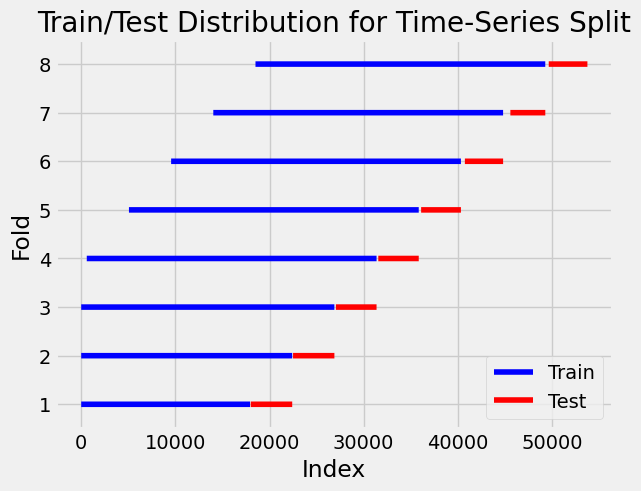

Total confident object score: 0.5336823734729493
Total number of confident objects 11460
Total number of profitable objects: 772
Scores: [-1799.9999999999955, -5600.0, 6200.0, 29650.000000000007, 1699.9999999999964, 5849.999999999993, 18350.000000000004, -15749.999999999996]


In [31]:
train_test = "fold"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
if "max_train_size" in params:
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

# set high and low bound for model predictions
# p > high_bound -> 1, p < low_bound -> 0
if "high_bound" in params:
    high_bound = params["high_bound"]
    del params["high_bound"]
    del params["low_bound"]
low_bound = 0

# add object weights
if "sample_weight" in params:
    sample_weight = params["sample_weight"]
    del params["sample_weight"]

if sample_weight == "cos":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
    train_df["weight"] = np.cos(train_df["weight"])
    sample_weight = True
elif sample_weight == "linear":
    train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
    train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min())
    sample_weight = True


params["objective"] = "binary"
params["verbosity"] = -1
if params["boosting_type"] != "goss":
    params["subsample_freq"] = 1
else:
    params["subsample"] = None
    params["subsample_freq"] = None
params["importance_type"] = "gain"
params["metric"] = "average_precison"

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["result", "backtest_result", "oof_conf_score", 
                                                "profit_objects", "oof_conf_obj_num", "scores"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=750)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv", index=False)

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight, 
                                                                      n_folds=CFG.n_folds, low_bound=low_bound, 
                                                                      high_bound=high_bound, train_test="fold", 
                                                                      max_train_size=max_train_size, verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)

    print(80 * "=")
    print(f"Total confident object score: {oof_conf_score}\n"
          f"Total number of confident objects {oof_conf_obj_num}\n"
          f"Total number of profitable objects: {round((2 * oof_conf_score - 1) * oof_conf_obj_num)}")
    
    scores = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Scores: {scores}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, sample_weight, 
                                    n_folds=8, low_bound=low_bound, 
                                    high_bound=high_bound, train_test="inference", 
                                    max_train_size=max_train_size, verbose=False)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

In [ ]:
_, new_scores, _, _, _ = model_train(train_df[train_df["time"] < CFG.last_date], 
                                          features + features_to_add, params, sample_weight, 
                                          n_folds=5, low_bound=0, 
                                          high_bound=high_bound, train_test="fold", 
                                          max_train_size=max_train_size, verbose=False)

print(best_scores)
print(new_scores)

### Test result of the new model against the result of the old model

In [32]:
# # TSS fold scores with sample weight
# a =  [385.00000000000085, -3110.0000000000036, -8865.0, -979.9999999999998, 7229.999999999995, -17095.0, 23465.000000000007, 16540.000000000007]
# # TSS fold scores with threshold 0.5
# b =  [1955.0, 54.999999999998074, -315.0, -210.0, 2364.9999999999995, 6645.0, 10680.0, -3554.9999999999995]

# ttest_rel(b, a, alternative="greater")

### Visualize train results

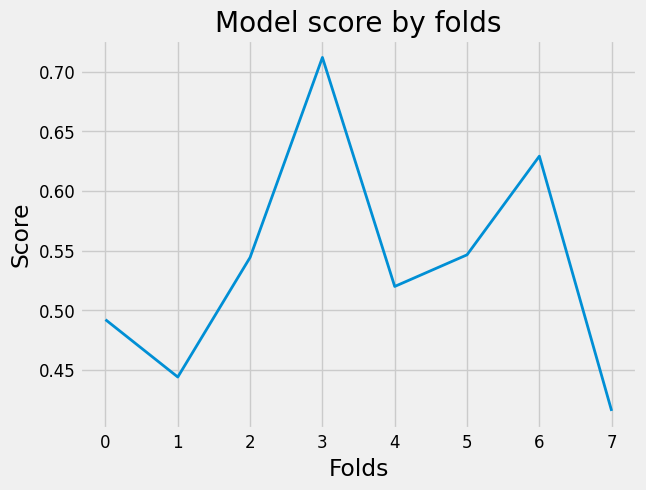

In [33]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores, linewidth=2)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Backtest model

I don't consider funding fees because the can be both positive and negative. I can do it because typical funding fee is positive and majority of my trade are shorts, so I can even earn on funding. But I think it's better not to consider it at all.


  0%|          | 0/11449 [00:00<?, ?it/s]

Result balance increase is 8.38%


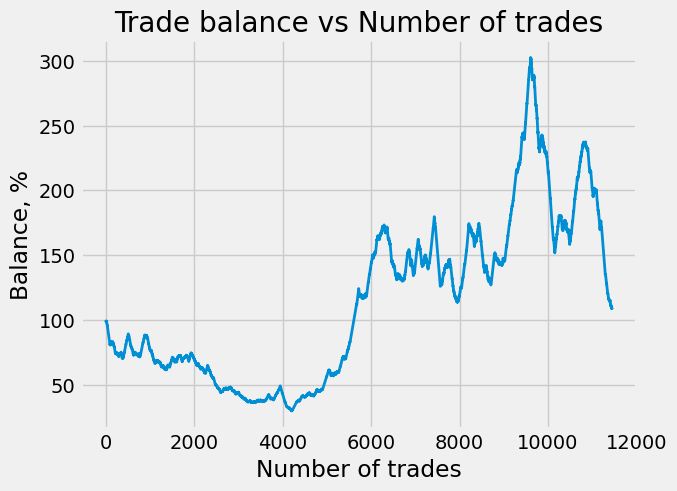

In [34]:
if not CFG.optimize and train_test == "fold":
    result, backtest_df = backtest(train_df, oof, val_idxs, high_bound, show_progress=True, 
                                max_num_simult_trades=CFG.max_num_simult_trades)
        
    # plot the balance
    backtest_plot = backtest_df["balance"].reset_index(drop=True)
    backtest_plot = backtest_plot * 100

    print(f"Result balance increase is {round(result, 3)}%")

    plt.xlabel('Number of trades')
    plt.ylabel('Balance, %')
    plt.title('Trade balance vs Number of trades')
    backtest_plot.plot(linewidth=2);

### Display PR curve for fold predictions

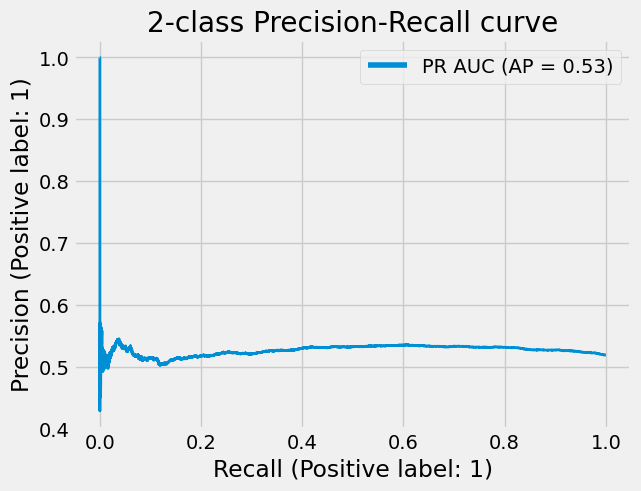

In [35]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold for fold predictions

ic| bound: 0.41
    score: 0.53515
    obj_num: 12290
    obj_pct: 0.58
    obj_profit: 864
ic| bound: 0.411
    score: 0.53491
    obj_num: 12273
    obj_pct: 0.58
    obj_profit: 857
ic| bound: 0.412
    score: 0.53505
    obj_num: 12255
    obj_pct: 0.58
    obj_profit: 859
ic| bound: 0.413
    score: 0.53474
    obj_num: 12234
    obj_pct: 0.58
    obj_profit: 850
ic| bound: 0.414
    score: 0.53486
    obj_num: 12207
    obj_pct: 0.58
    obj_profit: 851
ic| bound: 0.415
    score: 0.5349
    obj_num: 12191
    obj_pct: 0.58
    obj_profit: 851
ic| bound: 0.416
    score: 0.53516
    obj_num: 12174
    obj_pct: 0.58
    obj_profit: 856
ic| bound: 0.417
    score: 0.53482
    obj_num: 12148
    obj_pct: 0.58
    obj_profit: 846
ic| bound: 0.418
    score: 0.53464
    obj_num: 12124
    obj_pct: 0.58
    obj_profit: 840
ic| bound: 0.419
    score: 0.53491
    obj_num: 12103
    obj_pct: 0.57
    obj_profit: 845
ic| bound: 0.42
    score: 0.53472
    obj_num: 12081
    obj_pct: 0.57


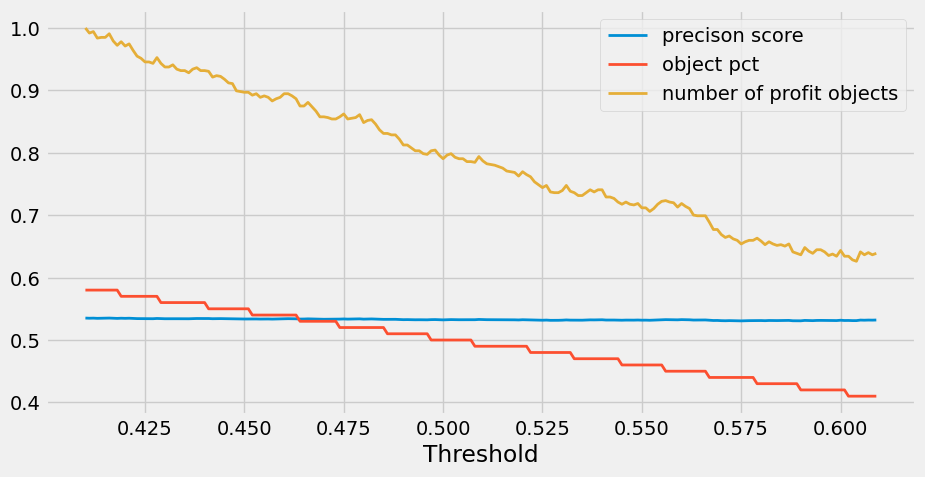

In [36]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

### Model feature importance

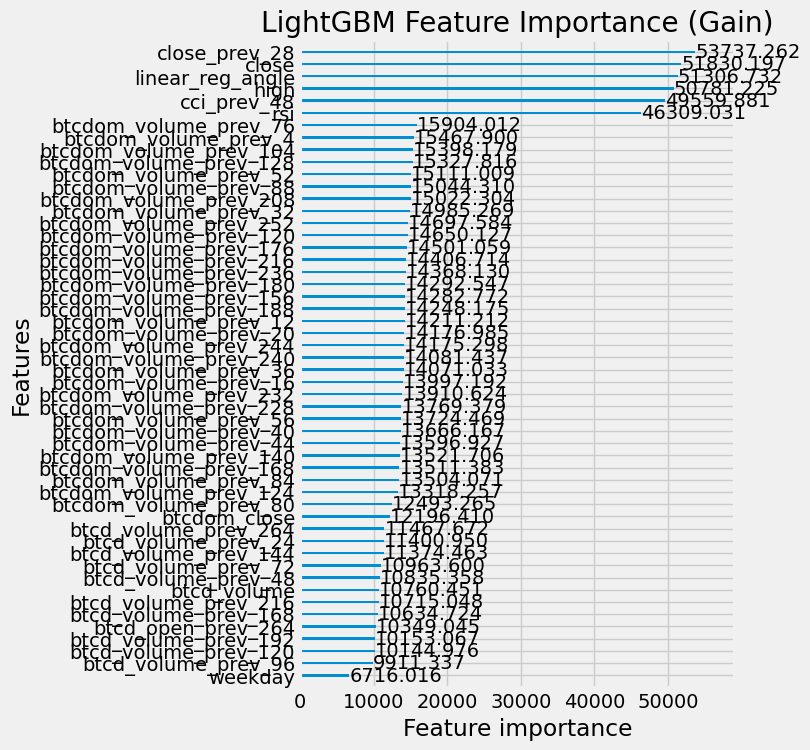

In [37]:
if not CFG.optimize and train_test == "fold":
    lgb.plot_importance(model, importance_type="gain", figsize=(5, 8), title="LightGBM Feature Importance (Gain)")
    plt.show()

# Error analysis

### Distribution of model pseudo-residuals

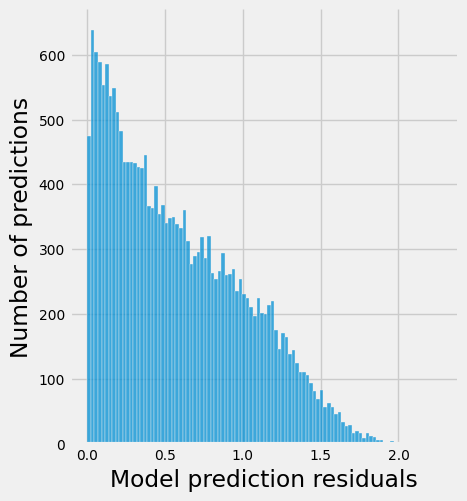

In [38]:
def logloss(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    """LogLoss terms"""
    if (y_pred <= 0).any() or (y_pred >= 1).any():
        raise ValueError("y_pred must be between 0 and 1")
    if ((y_true != 0) & (y_true != 1)).any():
        raise ValueError("y_true must be 0 or 1")
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length")
    return y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)


if not CFG.optimize and train_test == "fold":
    residual_df = train_df.loc[val_idxs, ["target"]]
    residual_df["pred"] = oof.ravel()
    y_true = residual_df["target"].values
    y_pred = residual_df["pred"].values
    residuals = -logloss(y_true, y_pred)
    residual_df["residuals"] = residuals
    
    sns.displot(np.log1p(residuals), bins=100)

    plt.xlabel("Model prediction residuals")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Pseudo-residuals vs Predictions plot

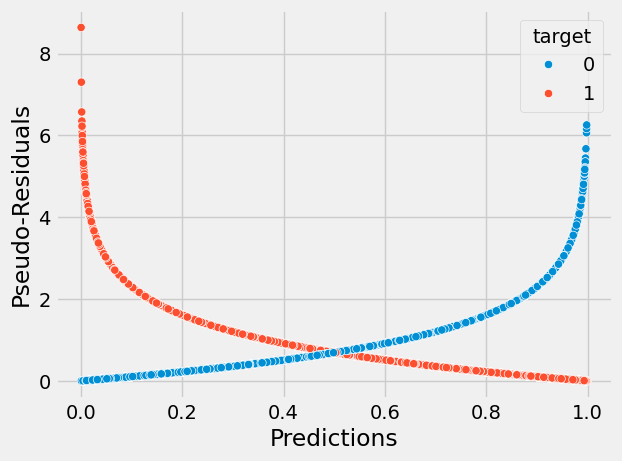

In [39]:
if not CFG.optimize and train_test == "fold":
    sns.scatterplot(residual_df, x="pred", y="residuals", hue="target")
    plt.xlabel("Predictions")
    plt.ylabel("Pseudo-Residuals");

### Residual stat tests

In [40]:
from stat_tests import test_normality, test_unbiased, test_homoscedasticity

if not CFG.optimize and train_test == "fold":
    display(test_normality(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is not normal
    display(test_unbiased(y_true, y_pred, alpha=0.05)) # p-value < 0.05 -> residuals distribution is biased
    display(test_homoscedasticity(y_true, y_pred, bins=30, alpha=0.05)) # p-value < 0.05 -> residuals distribution is heteroscedastic

p-value may not be accurate for N > 5000.


(0.0, True)

(1.6935398694987282e-05, True)

(2.3487982284270434e-223, True)

### Show worst predictions

In [41]:
if not CFG.optimize and train_test == "fold":
    worst_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(10).index
    worst_idxs_df = train_df.loc[worst_idxs, ["time", "ticker", "target", "ttype"]]
    worst_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals", ascending=False).head(10)["pred"]
    worst_idxs_df

### Show best predictions

In [42]:
if not CFG.optimize and train_test == "fold":
    best_idxs = residual_df.query("pred >= @high_bound").sort_values("residuals").head(10).index
    best_idxs_df = train_df.loc[best_idxs, ["time", "ticker", "target", "ttype"]]
    best_idxs_df["pred"] = residual_df.query("pred >= @high_bound").sort_values("residuals").head(10)["pred"]
    best_idxs_df

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- ticker price doesn't reach the cls_target_ratio_tp or cls_target_ratio_sl thresholds yet

- errors in the data preparation pipeline make model give different predictions

- bot was used in debug mode

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- different time for prediction

- there are NaNs in the ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [43]:
if not CFG.optimize:
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred", "target", "pattern"]]
    res = cap_max_num_simult_trades(res, CFG.max_num_simult_trades)
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res[["time", "ticker", "ttype", "pred", "target"]].tail(50))

Timestamp('2024-10-20 22:00:00')

Timestamp('2024-12-22 03:00:00')

0    1258
1    1216
Name: target, dtype: int64

0    0.508488
1    0.491512
Name: target, dtype: float64

,time,ticker,ttype,pred,target
2424,2024-12-20 16:00:00,BATUSDT,buy,0.873855,0
2425,2024-12-20 16:00:00,BCHUSDT,buy,0.815569,0
2426,2024-12-20 16:00:00,PNUTUSDT,buy,0.945244,0
2427,2024-12-20 16:00:00,1000XUSDT,buy,0.749366,0
2428,2024-12-20 16:00:00,BENDOGUSDT,buy,0.827661,0
2429,2024-12-20 16:00:00,ZECUSDT,buy,0.816061,0
2430,2024-12-20 16:00:00,SUNDOGUSDT,buy,0.781681,0
2431,2024-12-20 16:00:00,ALEOUSDT,buy,0.470792,0
2432,2024-12-20 16:00:00,MEMEFIUSDT,buy,0.944609,0
2433,2024-12-20 16:00:00,XMRUSDT,buy,0.793372,0


In [44]:
# Timestamp('2024-10-20 21:00:00')
# Timestamp('2024-12-22 01:00:00')
# 1    1288
# 0    1265
# Name: target, dtype: int641    0.504505
# 0    0.495495
# Name: target, dtype: float64

### Plot rolling mean precision score of the model predictions for the test data

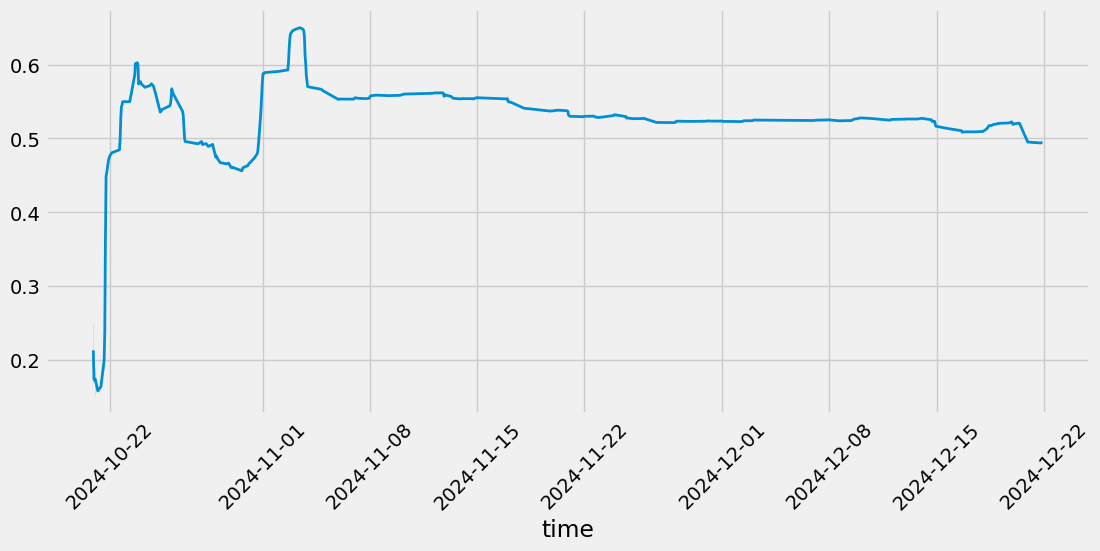

In [45]:
if not CFG.optimize:
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

### Show model uncertainty on test data

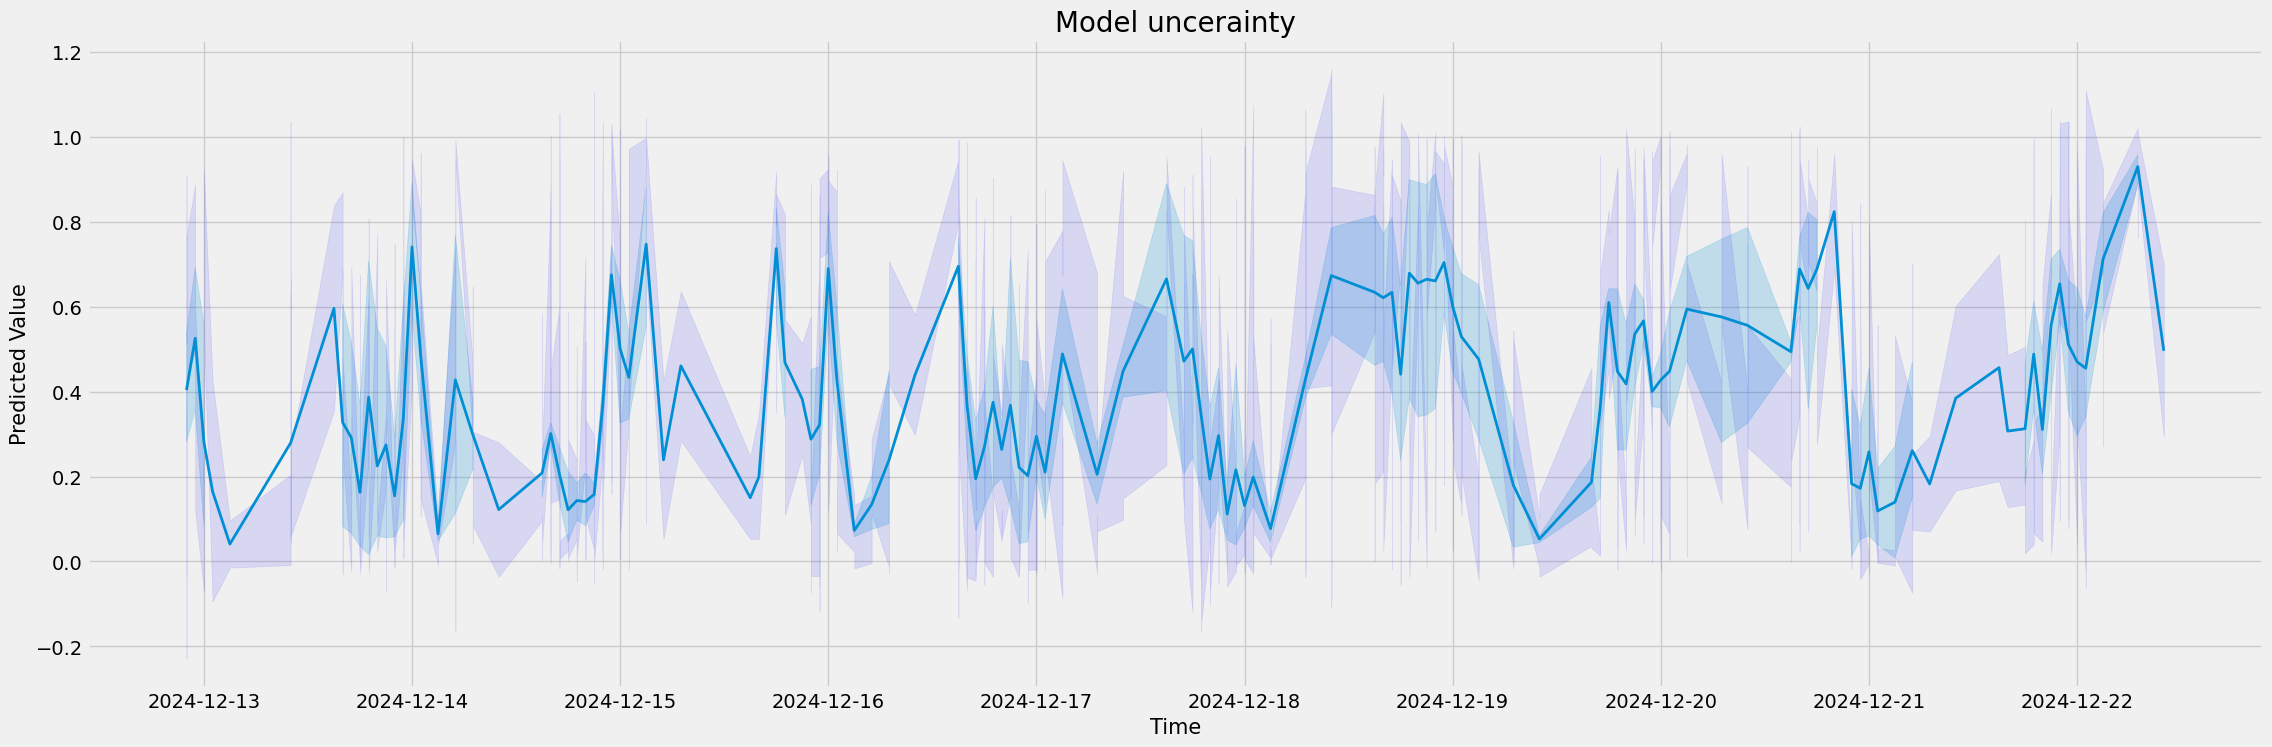

In [46]:
from boosting_uncertainty import predict_with_uncertainty

mask = train_df["time"] >= train_df["time"].max() - pd.to_timedelta(10, unit="d")
prediction_dict = predict_with_uncertainty(model, train_df.loc[mask, features], k=20)

ticker = train_df.loc[mask, "ticker"]
time = train_df.loc[mask, "time"]

pred = prediction_dict.pred_virt#[mask]
lcb = prediction_dict.lcb#[mask]
ucb = prediction_dict.ucb#[mask]

plt.figure(figsize=(25, 8))
plt.title("Model uncerainty", fontsize=20)
sns.lineplot(x=time, y=pred, linewidth=2)
plt.fill_between(time, lcb, ucb, color='b', alpha=.1)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Predicted Value", fontsize=15);

# Compare indicator / signal values for bot and optimizer

In [47]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "sell"
# ticker = "BADGERUSDT"
# month = 7
# day = 15
# hour = 23
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# x["time"] = pd.to_datetime(x["time"])
# y["time"] = pd.to_datetime(y["time"])
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# # x = x.drop(columns=["time_4h"])
# # y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols])